## Data from sediment 
This notebook will focus on microbiome data collected from sediment of watertanks holding fish with different probiotic supplementation added

In [4]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
# for tensorboard logs
import datetime
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold
from functions import *
from sklearn.preprocessing import LabelEncoder


In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/paq88/Fish_neural_network_classifier/refs/heads/main/sed_based/Sed/sed_bacteria_full_feature_table.csv')
print(df.shape)
print(len(df["pond"].unique()))
df.head()



(50, 228)
25


,pond,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Cyanobacteriales;f__Phormidiaceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
0,Sed_S10,111.0,128.0,122.0,101.0,84.0,44.0,42.0,52.0,240.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sed_S10,18.0,150.0,10.0,129.0,0.0,0.0,30.0,32.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sed_S11,81.0,21.0,29.0,90.0,NaN,8.0,10.0,NaN,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Sed_S11,3.0,13.0,18.0,3.0,NaN,3.0,18.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sed_S12,171.0,67.0,109.0,76.0,23.0,31.0,NaN,1.0,352.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


After the data look and checkup we can see that the dataset cosists of 227 bacteria famillies (columns) which we will treat as features, and 50 rows holding 25 unique values each of those represents one pond, ponds are divided into 5 different experimental setups we will have to decode that. Also there are two values per pond which indicate two points in time. We will perform classification between those two points to see if model is able to notice any significant changes and if it does use feature selection methods to see which bacteria is impacted by time alone regardless of supplementation. Later we will perform classification based on different experimental setups on both timepoints (one timepoint at the time) to see if there are changes between those.  

In [3]:
df.fillna(0, inplace=True)
df.describe()

,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Cyanobacteriales;f__Phormidiaceae,d__Bacteria;p__Desulfobacterota;c__Syntrophia;o__Syntrophales;f__uncultured,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,87.880000,88.440000,238.540000,60.020000,13.140000,14.420000,17.660000,7.420000,103.480000,39.040000,...,0.440000,0.720000,0.460000,0.30000,0.900000,0.260000,0.240000,0.220000,0.220000,0.200000
std,72.437909,65.694767,359.278484,40.221068,21.783733,21.364753,24.860927,11.510581,127.867636,31.416855,...,2.214608,4.549232,3.252691,2.12132,4.704535,1.838478,1.697056,1.555635,1.555635,1.414214
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,34.500000,24.000000,33.250000,0.000000,0.000000,0.000000,0.000000,3.250000,10.250000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,82.000000,73.500000,88.500000,56.500000,4.000000,2.000000,6.000000,1.500000,51.000000,36.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,126.250000,121.000000,297.000000,80.000000,19.500000,22.000000,28.000000,10.000000,196.750000,56.750000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,368.000000,256.000000,1898.000000,170.000000,103.000000,86.000000,113.000000,52.000000,463.000000,130.000000,...,13.000000,32.000000,23.000000,15.00000,30.000000,13.000000,12.000000,11.000000,11.000000,10.000000


In [4]:
classes = np.tile([0, 1], 25)
#df.drop(columns=["class"], inplace=True)
df.insert(1,"class_timepoint",  classes)

In [5]:
target = ["class_timepoint"]
predictors = list(set(df.columns) - set(["class_timepoint", "pond"]))


In [6]:
df_norm = df.copy()
X_norm = normalize(df[predictors], norm='max', axis=0, copy=True, return_norm=False)
df_norm[predictors] = X_norm


In [7]:
X=df_norm[predictors].values
y=df["class_timepoint"].values
yt = keras.utils.to_categorical(y, 2)
X_train, X_test, y_train, y_test = train_test_split(X,yt,test_size=0.3,random_state=111,stratify = yt,shuffle = True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(35, 227) (15, 227) (35, 2) (15, 2)


Explanation of pond coding

| number | setup | pond numbers | water supplementation | feed suplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

### Modeling timepoints only

#### Model building


In [8]:
model1 = keras.Sequential()



model1.add(keras.layers.Dense(256,input_shape=(X_train.shape[1],),activation='relu'))


model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(64, activation ='relu'))
model1.add(keras.layers.Dropout(rate=0.25))
#model1.add(keras.layers.Dense(16, activation ='relu'))

model1.add(keras.layers.Dense(2, activation ='softmax'))

model1.summary()

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        58,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,946 (292.76 KB)

 Trainable params: 74,946 (292.76 KB)

 Non-trainable params: 0 (0.00 B)

#### Model compiling

In [9]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model1.compile(optimizer = optimizer, loss = loss, metrics=metrics)

#### Model fitting

In [10]:
history1=model1.fit(X_train, y_train, epochs = 500, verbose = 1, shuffle = True, validation_data=(X_test, y_test))


Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.5979 - loss: 0.6872 - val_accuracy: 0.5333 - val_loss: 0.6944
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4905 - loss: 0.7133 - val_accuracy: 0.5333 - val_loss: 0.6943
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5095 - loss: 0.6753 - val_accuracy: 0.6000 - val_loss: 0.6941
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5979 - loss: 0.6759 - val_accuracy: 0.6000 - val_loss: 0.6941
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4696 - loss: 0.7013 - val_accuracy: 0.6000 - val_loss: 0.6940
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5095 - loss: 0.6979 - val_accuracy: 0.6000 - val_loss: 0.6938
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7452 - loss: 0.6468 - val_accuracy: 0.6000 - val_loss: 0.6937
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6464 - loss: 0.6573 - val_accuracy: 0.6000 - val_loss

### Model evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4667 - loss: 1.6631

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4667 - loss: 1.6631
[1.663116693496704, 0.46666666865348816]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted values: [0 0 0 1 0 0 0 0 1 0 1 1 0 0 0]
True values: [1 1 0 0 0 1 1 1 1 1 1 0 0 0 0]


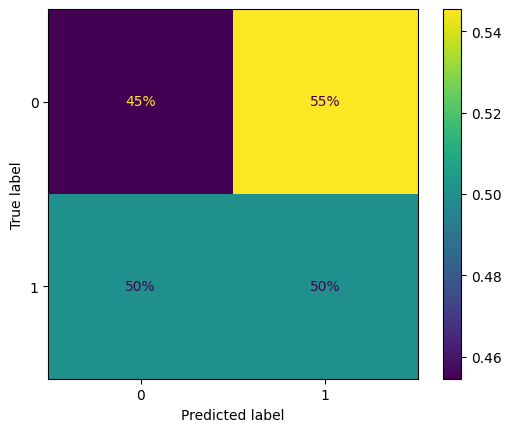

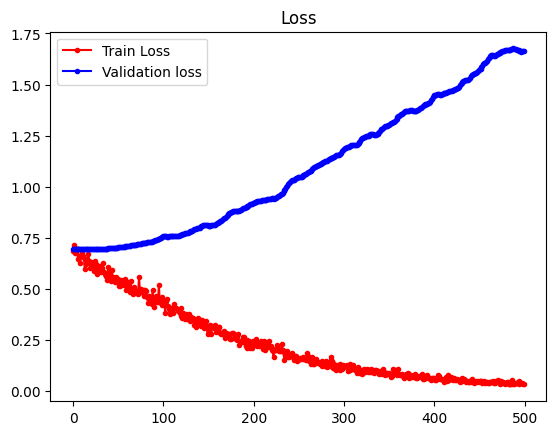

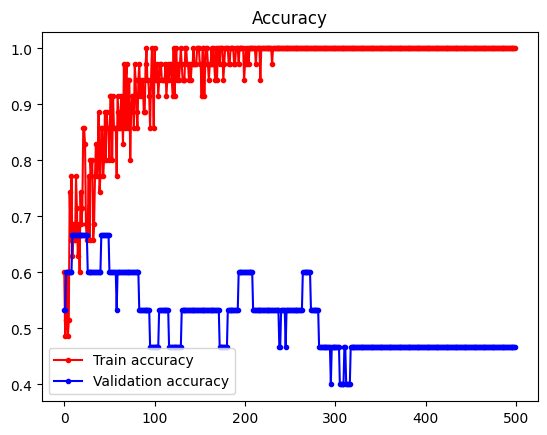

In [11]:
evaluate_model(model1, history1, X_test, y_test)

We can see that model is not suffering from overfitting problem, however the results are bad with accuracy barely exceeding 0.6 where 0.5 is baseline for randomly assigning classes. Confusion Matrix also reveals that model is not far from random choices, this could mean two things:
1. Model is bad 
2. There are no differencecs to be found 

As we checked different models and it is suspected that the change in time is depended on different probiotic supplementation we will not go down this path, second thing we will check in downstream analysys.

### Modeling differences between Classes for both timepoints at the same time

In [12]:

def pond_decoder(x,codes):
    
    x=x.replace('S','')
    num = int(x.split("_")[1])
    
    
    for key, value_list in codes.items():
        if num in value_list:
            return key
    
    return None   

In [13]:
df.head()

,pond,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
0,Sed_S10,0,111.0,128.0,122.0,101.0,84.0,44.0,42.0,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Sed_S10,1,18.0,150.0,10.0,129.0,0.0,0.0,30.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Sed_S11,0,81.0,21.0,29.0,90.0,0.0,8.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Sed_S11,1,3.0,13.0,18.0,3.0,0.0,3.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Sed_S12,0,171.0,67.0,109.0,76.0,23.0,31.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
len(predictors)

227

In [15]:
codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}

df['class_pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))
df_norm['class_pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))


C:\Users\marek\AppData\Local\Temp\ipykernel_12108\2389808530.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_norm['class_pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))


In [16]:
X = df[predictors].values
y=df["class_pond"].values
yt = keras.utils.to_categorical(y, 5)
X_train, X_test, y_train, y_test = train_test_split(X,yt,test_size=0.3,random_state=111,stratify = yt,shuffle = True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(35, 227) (15, 227) (35, 5) (15, 5)


In [17]:
model2 = keras.Sequential()



model2.add(keras.layers.Dense(256,input_shape=(X_train.shape[1],),activation='relu'))


#model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='relu'))
#model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

model2.summary()

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │        58,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,941 (296.64 KB)

 Trainable params: 75,941 (296.64 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

In [19]:
history2=model2.fit(X_train, y_train, epochs = 300, verbose = 1, shuffle = True, validation_data=(X_test, y_test))

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.1664 - loss: 43.4671 - val_accuracy: 0.1333 - val_loss: 33.5894
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1958 - loss: 37.5023 - val_accuracy: 0.2000 - val_loss: 32.2923
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2357 - loss: 33.4574 - val_accuracy: 0.2000 - val_loss: 31.5511
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2652 - loss: 30.4509 - val_accuracy: 0.2000 - val_loss: 30.9595
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2946 - loss: 27.9572 - val_accuracy: 0.2000 - val_loss: 30.1769
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2548 - loss: 25.6337 - val_accuracy: 0.2000 - val_loss: 29.2702
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2548 - loss: 24.2299 - val_accuracy: 0.2000 - val_loss: 28.3450
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3033 - loss: 21.7252 - val_accuracy: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1333 - loss: 11.7909
[11.790858268737793, 0.13333334028720856]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted values: [1 2 1 2 1 4 2 3 2 1 3 3 2 0 1]
True values: [2 0 0 4 2 3 3 3 4 1 2 0 1 1 4]


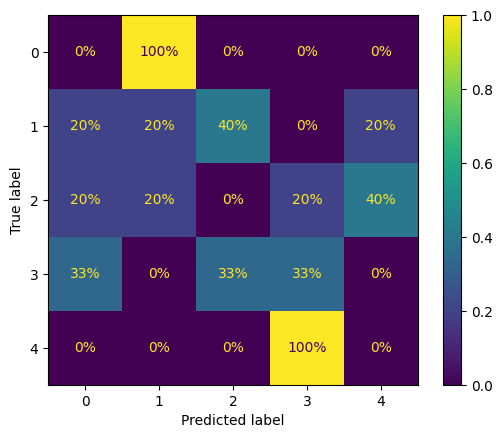

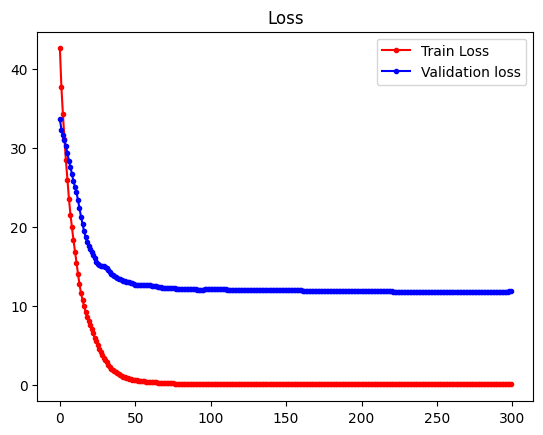

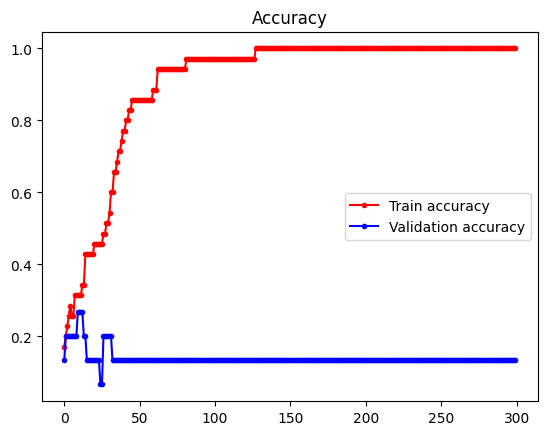

In [20]:
evaluate_model(model2, history2, X_test, y_test)

We can see here that there is problem with overfitting and becouse that there is not much viable learining happening after around epoch 80+ and once again accuracy is below random threshold of 0.2. The cause of that is probably becouse its hard for model to see differences in class only when timepoint probably plays viable role in change of bacteria abundance. We will now try to classify in only one timepoint for that we will chose second timepoint as that is the one where supplementation could have chance to impact microbiome. Issue with that is we will halve our dataset which is already small (from 50 to 25 samples).

### Modeling class differences in second timepoint

In [21]:
df_second_tp = df_norm[df_norm["class_timepoint"]==1]
print(df_second_tp.shape)
df_second_tp.head()

(25, 230)


,pond,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,...,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19,class_pond
1,Sed_S10,1,0.048913,0.585938,0.005269,0.758824,0.000000,0.000000,0.265487,0.615385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,Sed_S11,1,0.008152,0.050781,0.009484,0.017647,0.000000,0.034884,0.159292,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
5,Sed_S12,1,0.127717,0.343750,0.012645,0.247059,0.000000,0.023256,0.000000,0.173077,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,Sed_S13,1,0.380435,0.441406,0.197050,0.394118,0.029126,1.000000,0.000000,0.076923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
9,Sed_S14,1,0.491848,0.859375,0.131191,0.276471,0.223301,0.488372,0.353982,0.076923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [22]:
X=df_second_tp[predictors].values
y=df_second_tp["class_pond"].values
yt = keras.utils.to_categorical(y, 5)
X_train, X_test, y_train, y_test = train_test_split(X,yt,test_size=10,random_state=111,stratify = y,shuffle = True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(15, 227) (10, 227) (15, 5) (10, 5)


In [23]:
model3 = keras.Sequential()



model3.add(keras.layers.Dense(256,input_shape=(X_train.shape[1],),activation='relu'))


model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(64, activation ='relu'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(16, activation ='relu'))

model3.add(keras.layers.Dense(5, activation ='softmax'))

model3.summary()

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 256)            │        58,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,941 (296.64 KB)

 Trainable params: 75,941 (296.64 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model3.compile(optimizer = optimizer, loss = loss, metrics=metrics)

In [25]:
history3=model3.fit(X_train, y_train, epochs = 300, verbose = 1, shuffle = True, validation_data=(X_test, y_test))

Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2000 - loss: 1.5906 - val_accuracy: 0.1000 - val_loss: 1.6105
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2667 - loss: 1.6284 - val_accuracy: 0.1000 - val_loss: 1.6112
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2667 - loss: 1.6285 - val_accuracy: 0.0000e+00 - val_loss: 1.6116
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2000 - loss: 1.6163 - val_accuracy: 0.0000e+00 - val_loss: 1.6120
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4000 - loss: 1.5427 - val_accuracy: 0.0000e+00 - val_loss: 1.6125
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2667 - loss: 1.5890 - val_accuracy: 0.0000e+00 - val_loss: 1.6130
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2000 - loss: 1.5762 - val_accuracy: 0.0000e+00 - val_loss: 1.6135
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2667 - loss: 1.5674 - val_accuracy: 

In [26]:
predictions = model3.predict(X_test)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[[0.1820753  0.10729408 0.3403984  0.20387557 0.16635662]
 [0.3069253  0.20722283 0.18247648 0.16712601 0.13624936]
 [0.19520031 0.16659269 0.32074535 0.08863585 0.22882587]
 [0.23866692 0.11089061 0.2193554  0.09478675 0.3363003 ]
 [0.18534957 0.0679431  0.36164021 0.12969866 0.25536835]
 [0.25018153 0.22446758 0.16673578 0.20784786 0.1507672 ]
 [0.3397381  0.15627389 0.19084612 0.18234763 0.13079427]
 [0.22272539 0.05215107 0.40332446 0.05829915 0.26349995]
 [0.25840858 0.19496496 0.16805239 0.20811848 0.17045563]
 [0.28083822 0.07499926 0.25633237 0.21455504 0.1732751 ]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2000 - loss: 1.6115
[1.6115484237670898, 0.20000000298023224]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted values: [2 0 2 4 2 0 0 2 0 0]
True values: [1 2 2 4 0 4 3 0 1 3]


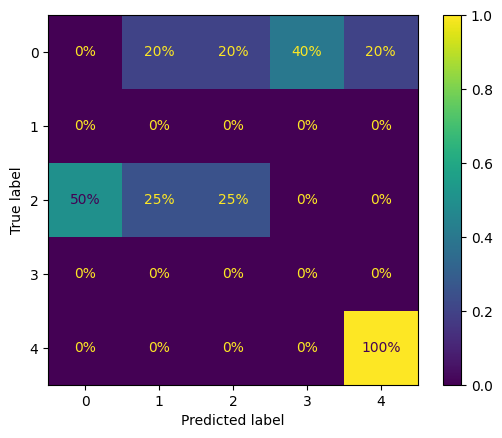

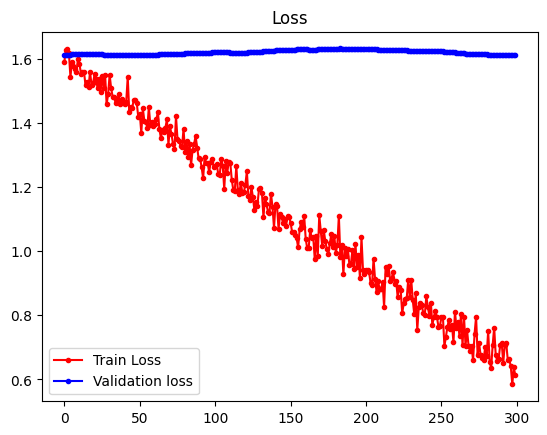

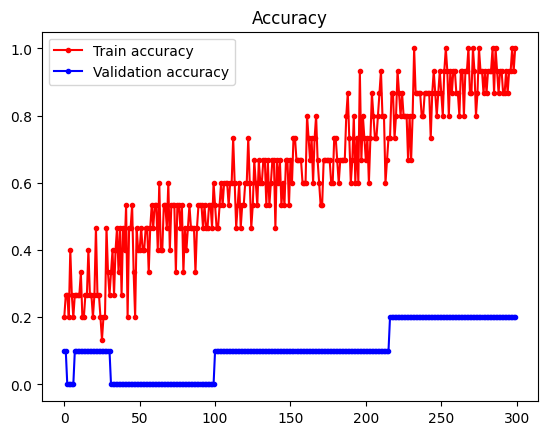

In [27]:
evaluate_model(model3, history3, X_test, y_test)

From those results we can clearly see that its very hard to work with neural networks on such small sample sizes even when we choose to have 20 samples aviable for training the results were bad. We can also check how the model behaves when we split data into 10 classes (timepoint*experimetnal_setup)

In [28]:
df.head()

,pond,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,...,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19,class_pond
0,Sed_S10,0,111.0,128.0,122.0,101.0,84.0,44.0,42.0,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,Sed_S10,1,18.0,150.0,10.0,129.0,0.0,0.0,30.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,Sed_S11,0,81.0,21.0,29.0,90.0,0.0,8.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,Sed_S11,1,3.0,13.0,18.0,3.0,0.0,3.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,Sed_S12,0,171.0,67.0,109.0,76.0,23.0,31.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [29]:
df["class_timepoint*pond"] = df["class_timepoint"].astype(str) + "_" + df["class_pond"].astype(str)
df_norm["class_timepoint*pond"] = df["class_timepoint"].astype(str) + "_" + df["class_pond"].astype(str)

C:\Users\marek\AppData\Local\Temp\ipykernel_12108\1246733335.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_norm["class_timepoint*pond"] = df["class_timepoint"].astype(str) + "_" + df["class_pond"].astype(str)


In [30]:
len(df["class_timepoint*pond"].unique())

10

In [31]:
X=df[predictors].values
y=df["class_timepoint*pond"].values
y = LabelEncoder().fit_transform(y)
y
yt = keras.utils.to_categorical(y, 10)
X_train, X_test, y_train, y_test = train_test_split(X,yt,test_size=10,random_state=111,stratify = y,shuffle = True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(40, 227) (10, 227) (40, 10) (10, 10)


In [35]:
model4 = keras.Sequential()



model4.add(keras.layers.Dense(256,input_shape=(X_train.shape[1],),activation='relu'))


model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(64, activation ='relu'))
model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(16, activation ='relu'))

model4.add(keras.layers.Dense(10, activation ='softmax'))

model4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 256)            │        58,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,026 (296.98 KB)

 Trainable params: 76,026 (296.98 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model4.compile(optimizer = optimizer, loss = loss, metrics=metrics)

In [39]:
history4=model4.fit(X_train, y_train, epochs = 300, verbose = 1, shuffle = True, validation_data=(X_test, y_test))

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2667 - loss: 4.1243 - val_accuracy: 0.2000 - val_loss: 4.2980
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2708 - loss: 3.2869 - val_accuracy: 0.2000 - val_loss: 4.2802
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3542 - loss: 4.1701 - val_accuracy: 0.2000 - val_loss: 4.2684
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2292 - loss: 4.9528 - val_accuracy: 0.2000 - val_loss: 4.2440
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2333 - loss: 4.1106 - val_accuracy: 0.2000 - val_loss: 4.2116
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3208 - loss: 4.8887 - val_accuracy: 0.2000 - val_loss: 4.1873
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3417 - loss: 3.4968 - val_accuracy: 0.2000 - val_loss: 4.1748
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2938 - loss: 3.2503 - val_accuracy: 0.2000 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1000 - loss: 4.1775
[4.177490711212158, 0.10000000149011612]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted values: [2 6 0 3 6 6 8 6 8 8]
True values: [6 2 9 0 7 5 4 3 1 8]


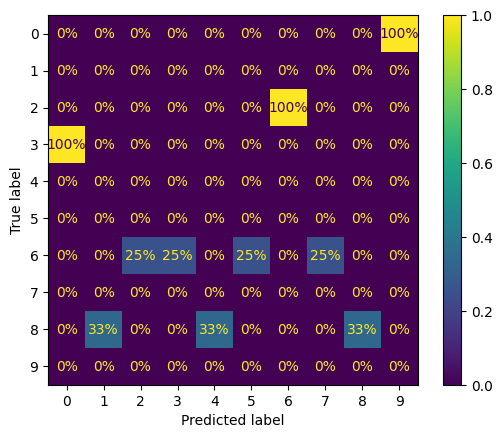

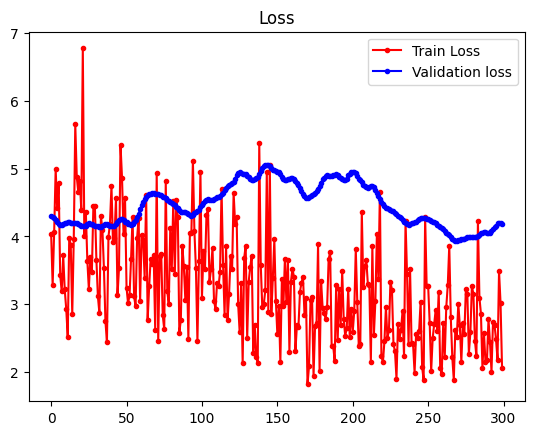

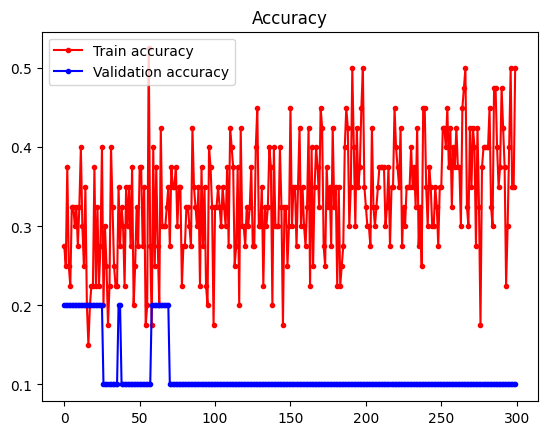

In [40]:
evaluate_model(model4, history4, X_test, y_test)

Although we dont see signs of overfitting accuracy is lackluster either, close to random. We will now reuse 2 class classification approach from gut dataset. This time we will use enviromental.
supplementation as class. This will be in next notebook Sediment_2.ipynb

,pond,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,...,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19,class_pond,class_timepoint*pond
0,Sed_S10,0,111.0,128.0,122.0,101.0,84.0,44.0,42.0,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0_2
1,Sed_S10,1,18.0,150.0,10.0,129.0,0.0,0.0,30.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1_2
2,Sed_S11,0,81.0,21.0,29.0,90.0,0.0,8.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0_4
3,Sed_S11,1,3.0,13.0,18.0,3.0,0.0,3.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1_4
4,Sed_S12,0,171.0,67.0,109.0,76.0,23.0,31.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0_1
5,Sed_S12,1,47.0,88.0,24.0,42.0,0.0,2.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1_1
6,Sed_S13,0,64.0,185.0,0.0,74.0,11.0,19.0,60.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0_3
7,Sed_S13,1,140.0,113.0,374.0,67.0,3.0,86.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1_3
8,Sed_S14,0,35.0,69.0,15.0,3.0,0.0,0.0,41.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0_0
9,Sed_S14,1,181.0,220.0,249.0,47.0,23.0,42.0,40.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1_0
